# Importing DICe data

Copyright 2021-today Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal**: Learn how to import the DICe output and create a efficient data structure for fast and easy visualization

In [1]:
# Import neccesary libraries
import os
import numpy as np
import pandas as pd
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## Intro

DICe generates one comma-separated tabular-like text file (.txt) for each correlation made so that correlating 10 images with a reference image results in ten different text files plus others with information about the correlation parameters. Each output file contains a variable number of columns, depending on the parameters you set up to measure in the DICe application. Our goal here is to explain how to read these files sequentially and how to store all the information for easy and efficient post-processing of the data. In summary:

- Read the DICe output text files
- Extract the parameters of interest from each file
- Store this information in an efficient data structure

In addition to some standard Python modules, we will use the libraries [Pandas](https://pandas.pydata.org/), for reading the text files and extracting the parameters of interest, and [NumPy](https://numpy.org/) for storing the data efficiently. In particular, we are going to store the data in a NumPy array object like the one shown below

![](https://github.com/marcoalopez/Jupyter4DICe/blob/main/notebooks/figs/NumPy_ndarrays_v2.png?raw=true)

where the numbers represent values of the parameter of interest, the axis 0 and 1 correspond to the y and x coordinates of the values in the maps and the axis 2 to the different correlations performed.

> **DICe reference frame**: Image coordinates in DICe are measured from the top left corner of the image with x positive to the right and y positive downward. Rotations are positive clockwise (opposite of the right-hand rule).

## Step 1: Load/import data

In the code below, the loop finds and reads all the txt files within the _dataset_ folder and read the files using the Pandas ``read_csv`` method. Note that the filenames of interest begin with "DICe". Then, it extracts the displacement values in the x and y directions and the in-plane rotation and rearranges them as a data array. The DICE files used here contain 19 different fields (columns). For the sake of simplicity and example, I have considered only three fields here. In other notebooks, we will consider other fields. Lastly, the loop stack all the information in NumPy arrays. In step 2, we will see how to store everything in the same variable to keep things tidy (i.e. do not fill the scope with too many variables).

In [2]:
path = 'dataset/'

# loop to extract the data
count = 1
print('Stacking data...')

for filename in os.listdir(path):
    if filename.startswith('DICe') and filename.endswith('.txt'):
        
        # load the corresponding txt file
        df = pd.read_csv(path + filename, delimiter=',')
        
        # separate the different parameters of interest and reorganize them as a matrix
        disp_X = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_X')
        disp_Y = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_Y')
        rot_Z = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='ROTATION_Z')

        
        # generate the numpy arrays
        if count == 1:
            dispX_stack = np.array(disp_X)
            dispY_stack = np.array(disp_Y)
            rotZ_stack = np.array(rot_Z)
            print(f'first processing file: {filename}')
            print('it might take a while...') 
        
        else:
            dispX_stack = np.dstack((dispX_stack, np.array(disp_X)))
            dispY_stack = np.dstack((dispY_stack, np.array(disp_Y)))
            rotZ_stack = np.dstack((rotZ_stack, np.array(rot_Z)))
        count += 1
        print('#', end = '')

print('')
print(f'last processing file: {filename}')
print('Done!')
print(f'Shape of arrays: {dispX_stack.shape}')

# remove variables that are not going to be used (to release RAM memory)
del df, count, filename, disp_X, disp_Y, rot_Z

Stacking data...
first processing file: DICe_solution_000.txt
it might take a while...
##########
last processing file: DICe_solution_074.txt
Done!
Shape of arrays: (377, 189, 10)


## Step 2: Understand the data structure

The loop above generated three different NumPy arrays of shape (377, 189, 10), where the first two values correspond to the y and x coordinates, and the third one with the evolution with time (or deformation). That is, each array is a sequence of 10 maps (axis 2) with dimensions of 189 x 377 pixels ``[y coordinates, x coordinates, time steps]``. To access the different correlation maps, we proceed as follows

```python
dispX_stack[:, :, 0]
```

in the example above, we first declare the array followed by square brackets considering all $y$ and $x$ coordinates, using a colon, and the specific map we want to examine, in this case, the first of the sequence indicated by the index zero. Now, imagine that we want to know the mean and standard deviation of the displacement in the x-direction for such a map. We will proceed as follows:


In [3]:
# I use the numpy nanmean and nanstd because the datasets contains nan values
avg = np.nanmean(dispX_stack[:, :, 0])  # result can be negative due to the reference frame
std = np.nanstd(dispX_stack[:, :, 0])

print(f'mean = {avg:.2f} μm ± {std:.2f} (1-sigma)')

mean = -3.61 μm ± 0.11 (1-sigma)


If we want to estimate the evolution of the median with time instead, we would use the ``nanmedian`` NumPy method passing the array of interest and indicating that the median should be computed considering all the pixels (axis 0 and 1) for each time step (axis 2), then we would proceed as follows:

In [4]:
np.nanmedian(dispY_stack, axis=[0, 1])

array([8.1884 , 2.0515 , 0.80901, 0.40402, 0.30901, 0.69049, 0.71793,
       0.66932, 0.79474, 0.69118])

Note that we obtained an array with ten values that correspond to the average displacement in the y-direction of each map (the correlation performed was incremental and thus the displacement does not necessarily increase over time).

> Note: Since we are using NumPy arrays it is important to use NumPy methods for calculations as opposed to standard Python methods or standard Python modules such as ``math`` or ``statistics``, which are optimised for other types of structures. For example
>
>``np.sum(array)`` or ``array.sum()`` 👍  
>``sum(array)`` ❌

### How to keep your variables tidy

As we might have to handle several samples simultaneously and in order to avoid cluttering up the scope with multiple variables, we can use the Python ``SimpleNamespace`` to separate samples from quantities of interest (or _fields_). This method provides an easy way to store related variables within the same space or _object_. For example:

In [5]:
sample1 = SimpleNamespace(dispX=dispX_stack,
                          dispY=dispY_stack,
                          rotZ=rotZ_stack)

# list the different fields inside the variable sample1 
sorted(sample1.__dict__)

['dispX', 'dispY', 'rotZ']

To access the different fields just use the dot notation syntax (e.g. ``varname.field``) as follows

In [6]:
np.nanmedian(sample1.dispY, axis=[0, 1])

array([8.1884 , 2.0515 , 0.80901, 0.40402, 0.30901, 0.69049, 0.71793,
       0.66932, 0.79474, 0.69118])

> Alternatively, a Python dictionary can also be used for this. I find the "SimpleNamespace" method more practical in this case (just a matter of personal taste) and it will be what I will use in the different example notebooks.

## Step 3: Plot some data

As an example, let's plot the _in-plane_ rotation (rotation on the z-axis) stored in the field named ``rotZ`` and the time step 10 (index 9). Since in DICe clockwise and counter-clockwise rotations are considered positive and negative respectively, we will illustrate them with a divergent colour map centred at 0 (i.e. areas with no rotation). In the chosen colour map, purple indicates clockwise rotations and green the opposite.

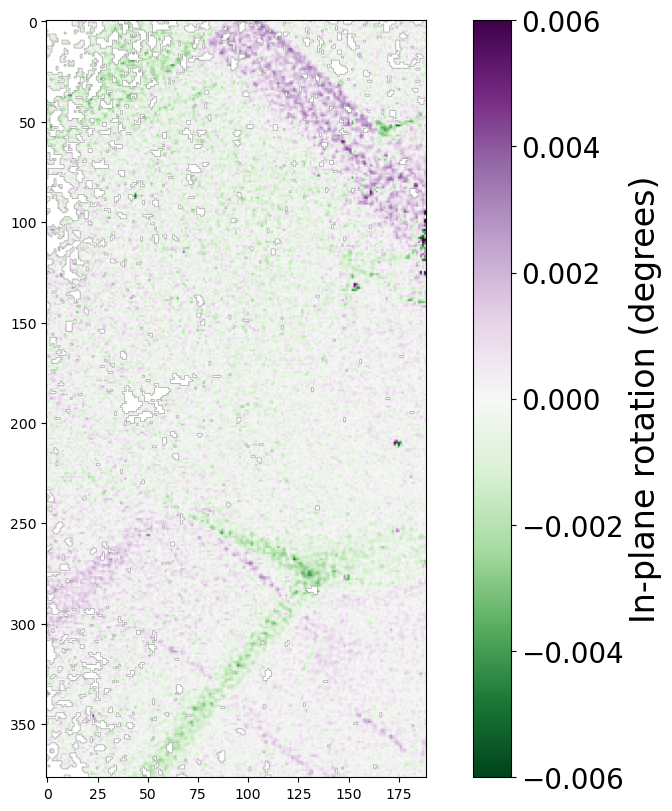

In [7]:
# initialize figure
fig, ax = plt.subplots(constrained_layout=True)

# image (take time step 10 --> [:, :, 9])
im = ax.imshow(sample1.rotZ[:, :, 9], vmin=-0.006, vmax=0.006, cmap='PRGn_r')

# add a color bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('In-plane rotation (degrees)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

In [8]:
import sys
import matplotlib as mpl
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)

Notebook tested in 2025-02-26 using:
Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Numpy 2.2.2
Pandas 2.2.3
Matplotlib 3.10.0
